## Work
1. 請嘗試寫一個 callback 用來記錄各類別在訓練過程中，對驗證集的 True Positive 與 True Negative

In [9]:
import os
import keras
import numpy as np

# Disable GPU
#os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [10]:
train, test = keras.datasets.cifar10.load_data()

In [11]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [12]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [13]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [14]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [15]:
# 載入 Callbacks
from keras.callbacks import Callback

# Record_fp_tp
class Record_tp_tn(Callback):
    """Code Here
    撰寫一個紀錄 ture positive 與 true negative 數量的 callbacks    
    """
    def on_train_begin(self, epoch, logs = {}):
        logs = logs or {}
        record_items = ["val_auc", "val_f1sc", "val_fp", "val_fn", "val_tp", "val_tn"]
        for i in record_items:
            if i not in self.params['metrics']:
                self.params['metrics'].append(i)
    
    def on_epoch_end(self, epoch, logs = {}, thres=0.5):
        logs = logs or {}
        y_true = self.validation_data[1].argmax(axis = 1)
        y_pred = self.model.predict(self.validation_data[0])
        y_pred = (y_pred[:, 1] >= thres) * 1
        
        logs["val_tp"] = np.sum(np.logical_and(y_pred == 1, y_true == 1))
        logs["val_tn"] = np.sum(np.logical_and(y_pred == 0, y_true == 0))
        
   
rec_tptn = Record_tp_tn()

In [16]:
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

"""Code Here
將 callbacks 放入模型訓練流程中
"""
model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[rec_tptn]
         )


# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["acc"]
valid_acc = model.history.history["val_acc"]

"""Code Here
將 tp/tn 從訓練完的模型中取出
"""
valid_tp = model.history.history["val_tp"]
valid_tn = model.history.history["val_tn"]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_4 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_5 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_6 (Batch (None, 128)               512       
__________

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.102227). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106216). Check your callbacks.
  % delta_t_median)


15360/50000 [========>.....................] - ETA: 7s - loss: 2.6725 - acc: 0.1596

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111701). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.116802). Check your callbacks.
  % delta_t_median)


18432/50000 [==========>...................] - ETA: 6s - loss: 2.6026 - acc: 0.1768

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.107826). Check your callbacks.
  % delta_t_median)


21504/50000 [===========>..................] - ETA: 5s - loss: 2.5396 - acc: 0.1932

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.121590). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.118423). Check your callbacks.
  % delta_t_median)


25600/50000 [==============>...............] - ETA: 4s - loss: 2.4808 - acc: 0.2081

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.116413). Check your callbacks.
  % delta_t_median)


32768/50000 [==================>...........] - ETA: 3s - loss: 2.3883 - acc: 0.2289- ETA: 3s - loss: 2.3986 - acc: 0.226

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111234). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.103431). Check your callbacks.
  % delta_t_median)


33792/50000 [===================>..........] - ETA: 2s - loss: 2.3765 - acc: 0.2316

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.113304). Check your callbacks.
  % delta_t_median)


35840/50000 [====================>.........] - ETA: 2s - loss: 2.3535 - acc: 0.2384

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.120884). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133643). Check your callbacks.
  % delta_t_median)


45056/50000 [==========================>...] - ETA: 0s - loss: 2.2690 - acc: 0.2591- ETA: 2s - loss: 2.3344 - acc: 0.2 - ETA: 1s - loss: 2.3043 - acc: 0.

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132147). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.129154). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.125835). Check your callbacks.
  % delta_t_median)


49152/50000 [============================>.] - ETA: 0s - loss: 2.2375 - acc: 0.2668

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.121941). Check your callbacks.
  % delta_t_median)


50000/50000 [==============================] - 10s 198us/step - loss: 2.2322 - acc: 0.2683 - val_loss: 2.1389 - val_acc: 0.3250
Epoch 2/50
 4096/50000 [=>............................] - ETA: 5s - loss: 1.8378 - acc: 0.3735

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.103722). Check your callbacks.
  % delta_t_median)


 8192/50000 [===>..........................] - ETA: 6s - loss: 1.8245 - acc: 0.3729

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.110703). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.117684). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.124666). Check your callbacks.
  % delta_t_median)


11264/50000 [=====>........................] - ETA: 5s - loss: 1.8235 - acc: 0.3714

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.110704). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.121674). Check your callbacks.
  % delta_t_median)


15360/50000 [========>.....................] - ETA: 5s - loss: 1.8130 - acc: 0.3724

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.127658). Check your callbacks.
  % delta_t_median)


18432/50000 [==========>...................] - ETA: 5s - loss: 1.8048 - acc: 0.3735

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.121176). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.126187). Check your callbacks.
  % delta_t_median)


29696/50000 [================>.............] - ETA: 3s - loss: 1.7822 - acc: 0.3822

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.112200). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108709). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.107711). Check your callbacks.
  % delta_t_median)


C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.105844). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108708). Check your callbacks.
  % delta_t_median)


36864/50000 [=====================>........] - ETA: 2s - loss: 1.7702 - acc: 0.3858

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.115276). Check your callbacks.
  % delta_t_median)


40960/50000 [=======================>......] - ETA: 1s - loss: 1.7677 - acc: 0.386

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114278). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.120677). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.126661). Check your callbacks.
  % delta_t_median)


47104/50000 [===========================>..] - ETA: 0s - loss: 1.7570 - acc: 0.3903

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128656). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.121675). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.120399). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.121786). Check your callbacks.
  % delta_t_median)


50000/50000 [==============================] - 9s 186us/step - loss: 1.7521 - acc: 0.3922 - val_loss: 1.7967 - val_acc: 0.3781
Epoch 3/50
 2048/50000 [>.............................] - ETA: 7s - loss: 1.6738 - acc: 0.4331

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163562). Check your callbacks.
  % delta_t_median)


 4096/50000 [=>............................] - ETA: 7s - loss: 1.6663 - acc: 0.4338

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.101726). Check your callbacks.
  % delta_t_median)


 8192/50000 [===>..........................] - ETA: 6s - loss: 1.6495 - acc: 0.4402

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.105718). Check your callbacks.
  % delta_t_median)


14336/50000 [=======>......................] - ETA: 5s - loss: 1.6428 - acc: 0.4351

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.105717). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.116688). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.116687). Check your callbacks.
  % delta_t_median)


18432/50000 [==========>...................] - ETA: 5s - loss: 1.6361 - acc: 0.4351

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.124167). Check your callbacks.
  % delta_t_median)


24576/50000 [=============>................] - ETA: 4s - loss: 1.6378 - acc: 0.4347- ETA: 4s - loss: 1.6347 - acc: 0

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.119679). Check your callbacks.
  % delta_t_median)


33792/50000 [===================>..........] - ETA: 2s - loss: 1.6334 - acc: 0.4343

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.121175). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.117186). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.115691). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.115192). Check your callbacks.
  % delta_t_median)


C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.107213). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111202). Check your callbacks.
  % delta_t_median)


43008/50000 [========================>.....] - ETA: 1s - loss: 1.6297 - acc: 0.435

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.120178). Check your callbacks.
  % delta_t_median)


49152/50000 [============================>.] - ETA: 0s - loss: 1.6256 - acc: 0.4361

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.123170). Check your callbacks.
  % delta_t_median)


50000/50000 [==============================] - 9s 178us/step - loss: 1.6252 - acc: 0.4360 - val_loss: 1.6907 - val_acc: 0.4112
Epoch 4/50
11264/50000 [=====>........................] - ETA: 5s - loss: 1.5670 - acc: 0.4584

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.101564). Check your callbacks.
  % delta_t_median)


19456/50000 [==========>...................] - ETA: 4s - loss: 1.5674 - acc: 0.4582- ETA: 4s - loss: 1.5703 - acc: 0.457

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.105443). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.102835). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108294). Check your callbacks.
  % delta_t_median)


22528/50000 [============>.................] - ETA: 4s - loss: 1.5680 - acc: 0.4569- ETA: 4s - loss: 1.5657 - acc: 0.458

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111412). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.119671). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.125235). Check your callbacks.
  % delta_t_median)


25600/50000 [==============>...............] - ETA: 3s - loss: 1.5668 - acc: 0.4568- ETA: 3s - loss: 1.5677 - acc: 0.456

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.126948). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.127447). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128052). Check your callbacks.
  % delta_t_median)


31744/50000 [==================>...........] - ETA: 2s - loss: 1.5656 - acc: 0.4565

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.127160). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.119822). Check your callbacks.
  % delta_t_median)


C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.116331). Check your callbacks.
  % delta_t_median)


39936/50000 [======================>.......] - ETA: 1s - loss: 1.5594 - acc: 0.4577

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.121318). Check your callbacks.
  % delta_t_median)


43008/50000 [========================>.....] - ETA: 1s - loss: 1.5579 - acc: 0.4581

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.129653). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.131648). Check your callbacks.
  % delta_t_median)


48128/50000 [===========================>..] - ETA: 0s - loss: 1.5537 - acc: 0.4587

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.126660). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.126163). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.123171). Check your callbacks.
  % delta_t_median)


49152/50000 [============================>.] - ETA: 0s - loss: 1.5531 - acc: 0.4593

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.118682). Check your callbacks.
  % delta_t_median)


50000/50000 [==============================] - 9s 178us/step - loss: 1.5529 - acc: 0.4592 - val_loss: 1.6384 - val_acc: 0.4272
Epoch 5/50
 5120/50000 [==>...........................] - ETA: 5s - loss: 1.5062 - acc: 0.4666

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.113695). Check your callbacks.
  % delta_t_median)


12288/50000 [======>.......................] - ETA: 5s - loss: 1.5076 - acc: 0.4692- ETA: 5s - loss: 1.5021 - acc: 0.47

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.112698). Check your callbacks.
  % delta_t_median)


14336/50000 [=======>......................] - ETA: 5s - loss: 1.5086 - acc: 0.4692

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114693). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.116189). Check your callbacks.
  % delta_t_median)


16384/50000 [========>.....................] - ETA: 4s - loss: 1.5093 - acc: 0.4686

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.112199). Check your callbacks.
  % delta_t_median)


20480/50000 [===========>..................] - ETA: 4s - loss: 1.5077 - acc: 0.4708

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114692). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111700). Check your callbacks.
  % delta_t_median)


25600/50000 [==============>...............] - ETA: 3s - loss: 1.5073 - acc: 0.4697

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.109208). Check your callbacks.
  % delta_t_median)


28672/50000 [================>.............] - ETA: 3s - loss: 1.5047 - acc: 0.4718

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.110204). Check your callbacks.
  % delta_t_median)


33792/50000 [===================>..........] - ETA: 2s - loss: 1.5041 - acc: 0.472

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.115191). Check your callbacks.
  % delta_t_median)


37888/50000 [=====================>........] - ETA: 1s - loss: 1.5028 - acc: 0.4741

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133642). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.136912). Check your callbacks.
  % delta_t_median)


46080/50000 [==========================>...] - ETA: 0s - loss: 1.4993 - acc: 0.4751- ETA: 1s - loss: 1.5000 - acc: 0.4

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.127244). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.121066). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.117077). Check your callbacks.
  % delta_t_median)


50000/50000 [==============================] - 9s 180us/step - loss: 1.4975 - acc: 0.4763 - val_loss: 1.6251 - val_acc: 0.4276
Epoch 6/50
 5120/50000 [==>...........................] - ETA: 5s - loss: 1.4660 - acc: 0.4908- ETA: 4s - loss: 1.4782 - acc: 0.4

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.117177). Check your callbacks.
  % delta_t_median)


 7168/50000 [===>..........................] - ETA: 6s - loss: 1.4507 - acc: 0.4993

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.119426). Check your callbacks.
  % delta_t_median)


12288/50000 [======>.......................] - ETA: 5s - loss: 1.4572 - acc: 0.493

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.118928). Check your callbacks.
  % delta_t_median)


18432/50000 [==========>...................] - ETA: 4s - loss: 1.4576 - acc: 0.4934- ETA: 4s - loss: 1.4556 - acc: 0.494

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.122672). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.122173). Check your callbacks.
  % delta_t_median)


20480/50000 [===========>..................] - ETA: 4s - loss: 1.4602 - acc: 0.4920

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.124168). Check your callbacks.
  % delta_t_median)


23552/50000 [=============>................] - ETA: 4s - loss: 1.4598 - acc: 0.492 - ETA: 4s - loss: 1.4576 - acc: 0.4928

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.125260). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.127753). Check your callbacks.
  % delta_t_median)


29696/50000 [================>.............] - ETA: 3s - loss: 1.4563 - acc: 0.4935

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.126903). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.123627). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.120020). Check your callbacks.
  % delta_t_median)


32768/50000 [==================>...........] - ETA: 2s - loss: 1.4576 - acc: 0.4932

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.117630). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.120906). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.112198). Check your callbacks.
  % delta_t_median)


35840/50000 [====================>.........] - ETA: 2s - loss: 1.4575 - acc: 0.4929

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.112136). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.110559). Check your callbacks.
  % delta_t_median)


49152/50000 [============================>.] - ETA: 0s - loss: 1.4534 - acc: 0.4934- ETA: 1s - loss: 1.4564 - a

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.123668). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.120177). Check your callbacks.
  % delta_t_median)


50000/50000 [==============================] - 9s 176us/step - loss: 1.4528 - acc: 0.4933 - val_loss: 1.5711 - val_acc: 0.4484
Epoch 7/50
 4096/50000 [=>............................] - ETA: 5s - loss: 1.4045 - acc: 0.510 - ETA: 5s - loss: 1.3997 - acc: 0.5137

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.101727). Check your callbacks.
  % delta_t_median)


11264/50000 [=====>........................] - ETA: 5s - loss: 1.4179 - acc: 0.5068- ETA: 5s - loss: 1.4069 - acc: 0.50 - ETA: 5s - loss: 1.4180 - acc: 0.50

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.109708). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108710). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.112700). Check your callbacks.
  % delta_t_median)


14336/50000 [=======>......................] - ETA: 5s - loss: 1.4145 - acc: 0.5109

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.119182). Check your callbacks.
  % delta_t_median)


17408/50000 [=========>....................] - ETA: 4s - loss: 1.4158 - acc: 0.5092

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.109707). Check your callbacks.
  % delta_t_median)


22528/50000 [============>.................] - ETA: 4s - loss: 1.4196 - acc: 0.5071- ETA: 4s - loss: 1.4163 - acc: 0.50

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.105085). Check your callbacks.
  % delta_t_median)


28672/50000 [================>.............] - ETA: 3s - loss: 1.4189 - acc: 0.5069

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111203). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.109706). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114194). Check your callbacks.
  % delta_t_median)


33792/50000 [===================>..........] - ETA: 2s - loss: 1.4169 - acc: 0.5071- ETA: 2s - loss: 1.4187 - acc: 0.5

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.125165). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.121127). Check your callbacks.
  % delta_t_median)


37888/50000 [=====================>........] - ETA: 2s - loss: 1.4145 - acc: 0.507

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.110156). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.121322). Check your callbacks.
  % delta_t_median)


40960/50000 [=======================>......] - ETA: 1s - loss: 1.4129 - acc: 0.5081

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111153). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.117137). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111526). Check your callbacks.
  % delta_t_median)


48128/50000 [===========================>..] - ETA: 0s - loss: 1.4135 - acc: 0.5074- ETA: 0s - loss: 1.4128 - acc: 0.

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114068). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.124694). Check your callbacks.
  % delta_t_median)


49152/50000 [============================>.] - ETA: 0s - loss: 1.4126 - acc: 0.5076

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.122201). Check your callbacks.
  % delta_t_median)


50000/50000 [==============================] - 9s 173us/step - loss: 1.4130 - acc: 0.5074 - val_loss: 1.5515 - val_acc: 0.4549
Epoch 8/50
 7168/50000 [===>..........................] - ETA: 5s - loss: 1.3778 - acc: 0.5240

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108950). Check your callbacks.
  % delta_t_median)


11264/50000 [=====>........................] - ETA: 5s - loss: 1.3718 - acc: 0.5248

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.109948). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111382). Check your callbacks.
  % delta_t_median)


18432/50000 [==========>...................] - ETA: 4s - loss: 1.3762 - acc: 0.5207- ETA: 4s - loss: 1.3754 - acc: 0.521

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.112439). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.112756). Check your callbacks.
  % delta_t_median)


22528/50000 [============>.................] - ETA: 4s - loss: 1.3766 - acc: 0.5205

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.116889). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.122172). Check your callbacks.
  % delta_t_median)


28672/50000 [================>.............] - ETA: 3s - loss: 1.3740 - acc: 0.5205

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.119180). Check your callbacks.
  % delta_t_median)


34816/50000 [===================>..........] - ETA: 2s - loss: 1.3712 - acc: 0.5224

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.104719). Check your callbacks.
  % delta_t_median)


39936/50000 [======================>.......] - ETA: 1s - loss: 1.3730 - acc: 0.5209

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.120678). Check your callbacks.
  % delta_t_median)


49152/50000 [============================>.] - ETA: 0s - loss: 1.3745 - acc: 0.5205- ETA: 0s - loss: 1.3727 - acc: 0

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.119680). Check your callbacks.
  % delta_t_median)


50000/50000 [==============================] - 9s 176us/step - loss: 1.3754 - acc: 0.5203 - val_loss: 1.5326 - val_acc: 0.4634
Epoch 9/50
 3072/50000 [>.............................] - ETA: 5s - loss: 1.3440 - acc: 0.5303

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.109539). Check your callbacks.
  % delta_t_median)


 6144/50000 [==>...........................] - ETA: 6s - loss: 1.3506 - acc: 0.5339

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161405). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.113940). Check your callbacks.
  % delta_t_median)


13312/50000 [======>.......................] - ETA: 5s - loss: 1.3491 - acc: 0.5326

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.100231). Check your callbacks.
  % delta_t_median)


17408/50000 [=========>....................] - ETA: 4s - loss: 1.3519 - acc: 0.5304- ETA: 4s - loss: 1.3521 - acc: 0.530

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.107431). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106232). Check your callbacks.
  % delta_t_median)


20480/50000 [===========>..................] - ETA: 4s - loss: 1.3499 - acc: 0.5315

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.103809). Check your callbacks.
  % delta_t_median)


24576/50000 [=============>................] - ETA: 3s - loss: 1.3482 - acc: 0.5321

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114297). Check your callbacks.
  % delta_t_median)


26624/50000 [==============>...............] - ETA: 3s - loss: 1.3441 - acc: 0.5334

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.112286). Check your callbacks.
  % delta_t_median)


31744/50000 [==================>...........] - ETA: 2s - loss: 1.3416 - acc: 0.5325- ETA: 3s - loss: 1.3447 - acc: 0.532 - ETA: 2s - loss: 1.3440 - acc: 0.53

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.110403). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.113358). Check your callbacks.
  % delta_t_median)


48128/50000 [===========================>..] - ETA: 0s - loss: 1.3428 - acc: 0.5313

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.105287). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106379). Check your callbacks.
  % delta_t_median)


50000/50000 [==============================] - 8s 153us/step - loss: 1.3438 - acc: 0.5309 - val_loss: 1.5143 - val_acc: 0.4664
Epoch 10/50
10240/50000 [=====>........................] - ETA: 5s - loss: 1.3023 - acc: 0.5451- ETA: 4s - loss: 1.3054 - acc: 0.5 - ETA: 5s - loss: 1.3007 - acc: 0.539 - ETA: 5s - loss: 1.3074 - acc: 0

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106714). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.116270). Check your callbacks.
  % delta_t_median)


13312/50000 [======>.......................] - ETA: 5s - loss: 1.3019 - acc: 0.5450

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.126243). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.131764). Check your callbacks.
  % delta_t_median)


18432/50000 [==========>...................] - ETA: 5s - loss: 1.3070 - acc: 0.5454- ETA: 5s - loss: 1.3087 - acc: 0.54

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.127775). Check your callbacks.
  % delta_t_median)


28672/50000 [================>.............] - ETA: 3s - loss: 1.3164 - acc: 0.5420- ETA: 4s - loss: 1.3095 - acc:

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.122564). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.121439). Check your callbacks.
  % delta_t_median)


32768/50000 [==================>...........] - ETA: 2s - loss: 1.3154 - acc: 0.5424- ETA: 3s - loss: 1.3155 - acc: 0.54

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.122750). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.125522). Check your callbacks.
  % delta_t_median)


36864/50000 [=====================>........] - ETA: 2s - loss: 1.3127 - acc: 0.5437

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.122730). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.120704). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.117722). Check your callbacks.
  % delta_t_median)


C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114187). Check your callbacks.
  % delta_t_median)


48128/50000 [===========================>..] - ETA: 0s - loss: 1.3148 - acc: 0.5427- ETA: 0s - loss: 1.3130 - acc: 0.5

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.123907). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.127515). Check your callbacks.
  % delta_t_median)


50000/50000 [==============================] - 9s 185us/step - loss: 1.3143 - acc: 0.5427 - val_loss: 1.5066 - val_acc: 0.4711
Epoch 11/50
15360/50000 [========>.....................] - ETA: 4s - loss: 1.2882 - acc: 0.5516- ETA: 4s - loss: 1.2851 - acc:

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.102726). Check your callbacks.
  % delta_t_median)


20480/50000 [===========>..................] - ETA: 4s - loss: 1.2879 - acc: 0.5520

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.122673). Check your callbacks.
  % delta_t_median)


23552/50000 [=============>................] - ETA: 3s - loss: 1.2885 - acc: 0.5519

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.119074). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.126662). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.121711). Check your callbacks.
  % delta_t_median)


27648/50000 [===============>..............] - ETA: 3s - loss: 1.2880 - acc: 0.5524- ETA: 3s - loss: 1.2877 - acc: 0.5

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.119217). Check your callbacks.
  % delta_t_median)


49152/50000 [============================>.] - ETA: 0s - loss: 1.2856 - acc: 0.5528- ETA: 1s - loss: 1.2846 - ac

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108211). Check your callbacks.
  % delta_t_median)


50000/50000 [==============================] - 8s 170us/step - loss: 1.2856 - acc: 0.5530 - val_loss: 1.4884 - val_acc: 0.4764
Epoch 12/50
11264/50000 [=====>........................] - ETA: 5s - loss: 1.2558 - acc: 0.5648

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.104191). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.110440). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.109941). Check your callbacks.
  % delta_t_median)


18432/50000 [==========>...................] - ETA: 5s - loss: 1.2550 - acc: 0.5656- ETA: 5s - loss: 1.2517 - acc: 0

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.123566). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.119317). Check your callbacks.
  % delta_t_median)


21504/50000 [===========>..................] - ETA: 4s - loss: 1.2553 - acc: 0.5651

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.118818). Check your callbacks.
  % delta_t_median)


29696/50000 [================>.............] - ETA: 3s - loss: 1.2594 - acc: 0.5631- ETA: 3s - loss: 1.2602 - acc: 0.562

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.119181). Check your callbacks.
  % delta_t_median)


40960/50000 [=======================>......] - ETA: 1s - loss: 1.2580 - acc: 0.5635

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.116636). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.113865). Check your callbacks.
  % delta_t_median)


47104/50000 [===========================>..] - ETA: 0s - loss: 1.2559 - acc: 0.5640

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.122892). Check your callbacks.
  % delta_t_median)


49152/50000 [============================>.] - ETA: 0s - loss: 1.2554 - acc: 0.5643

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.115910). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.124396). Check your callbacks.
  % delta_t_median)


50000/50000 [==============================] - 9s 177us/step - loss: 1.2557 - acc: 0.5641 - val_loss: 1.4790 - val_acc: 0.4811
Epoch 13/50
 3072/50000 [>.............................] - ETA: 5s - loss: 1.1823 - acc: 0.6006

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.102554). Check your callbacks.
  % delta_t_median)


12288/50000 [======>.......................] - ETA: 5s - loss: 1.2131 - acc: 0.584 - ETA: 5s - loss: 1.2141 - acc: 0.583

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.104222). Check your callbacks.
  % delta_t_median)


17408/50000 [=========>....................] - ETA: 5s - loss: 1.2276 - acc: 0.578

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.113198). Check your callbacks.
  % delta_t_median)


23552/50000 [=============>................] - ETA: 4s - loss: 1.2285 - acc: 0.5758- ETA: 4s - loss: 1.2295 - acc: 0.57 - ETA: 4s - loss: 1.2287 - acc: 0.57

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.123624). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.123389). Check your callbacks.
  % delta_t_median)


26624/50000 [==============>...............] - ETA: 3s - loss: 1.2342 - acc: 0.5741- ETA: 3s - loss: 1.2345 - acc: 0.573

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.120290). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.117925). Check your callbacks.
  % delta_t_median)


32768/50000 [==================>...........] - ETA: 2s - loss: 1.2317 - acc: 0.5748

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.121098). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.121024). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.122755). Check your callbacks.
  % delta_t_median)


36864/50000 [=====================>........] - ETA: 2s - loss: 1.2309 - acc: 0.5747

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128157). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128905). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.129797). Check your callbacks.
  % delta_t_median)


43008/50000 [========================>.....] - ETA: 1s - loss: 1.2294 - acc: 0.5746- ETA: 1s - loss: 1.2309 - acc: 0.5

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.127280). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.131293). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128422). Check your callbacks.
  % delta_t_median)


48128/50000 [===========================>..] - ETA: 0s - loss: 1.2303 - acc: 0.5740

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.119800). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.126781). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.117306). Check your callbacks.
  % delta_t_median)


49152/50000 [============================>.] - ETA: 0s - loss: 1.2295 - acc: 0.5746

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.105877). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.100891). Check your callbacks.
  % delta_t_median)


50000/50000 [==============================] - 9s 179us/step - loss: 1.2293 - acc: 0.5748 - val_loss: 1.4729 - val_acc: 0.4837
Epoch 14/50
 4096/50000 [=>............................] - ETA: 5s - loss: 1.1936 - acc: 0.5947

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.103105). Check your callbacks.
  % delta_t_median)


 7168/50000 [===>..........................] - ETA: 6s - loss: 1.1975 - acc: 0.5901

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111746). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.112873). Check your callbacks.
  % delta_t_median)


10240/50000 [=====>........................] - ETA: 5s - loss: 1.1959 - acc: 0.587 - ETA: 5s - loss: 1.1961 - acc: 0.5884

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.109420). Check your callbacks.
  % delta_t_median)


14336/50000 [=======>......................] - ETA: 5s - loss: 1.1993 - acc: 0.5874

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.120331). Check your callbacks.
  % delta_t_median)


17408/50000 [=========>....................] - ETA: 5s - loss: 1.1969 - acc: 0.5878

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.124022). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132998). Check your callbacks.
  % delta_t_median)


20480/50000 [===========>..................] - ETA: 4s - loss: 1.1997 - acc: 0.5868- ETA: 5s - loss: 1.1972 - acc: 0.587

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.137632). Check your callbacks.
  % delta_t_median)


50000/50000 [==============================] - 9s 181us/step - loss: 1.2052 - acc: 0.5833 - val_loss: 1.4614 - val_acc: 0.48853s - loss: 1.1999 - acc: 0 - ETA: 2s - loss: 1.1997 - ETA: 0s - loss: 1.2049 - acc: 0.5
Epoch 15/50
15360/50000 [========>.....................] - ETA: 4s - loss: 1.1802 - acc: 0.5968

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.101728). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.116190). Check your callbacks.
  % delta_t_median)


18432/50000 [==========>...................] - ETA: 4s - loss: 1.1851 - acc: 0.5946

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.113696). Check your callbacks.
  % delta_t_median)


21504/50000 [===========>..................] - ETA: 4s - loss: 1.1858 - acc: 0.5949

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.107712). Check your callbacks.
  % delta_t_median)


23552/50000 [=============>................] - ETA: 3s - loss: 1.1882 - acc: 0.5940

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.115460). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108331). Check your callbacks.
  % delta_t_median)


26624/50000 [==============>...............] - ETA: 3s - loss: 1.1831 - acc: 0.5954

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.104342). Check your callbacks.
  % delta_t_median)


29696/50000 [================>.............] - ETA: 3s - loss: 1.1833 - acc: 0.5947

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.112090). Check your callbacks.
  % delta_t_median)


34816/50000 [===================>..........] - ETA: 2s - loss: 1.1857 - acc: 0.5941- ETA: 2s - loss: 1.1838 - acc: 0.59

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.117455). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.122901). Check your callbacks.
  % delta_t_median)


36864/50000 [=====================>........] - ETA: 2s - loss: 1.1831 - acc: 0.5948

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.127556). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.125207). Check your callbacks.
  % delta_t_median)


41984/50000 [========================>.....] - ETA: 1s - loss: 1.1793 - acc: 0.5958

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134682). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.122720). Check your callbacks.
  % delta_t_median)


47104/50000 [===========================>..] - ETA: 0s - loss: 1.1813 - acc: 0.5946

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.115825). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.120683). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.116816). Check your callbacks.
  % delta_t_median)


49152/50000 [============================>.] - ETA: 0s - loss: 1.1801 - acc: 0.5945

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111884). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.110523). Check your callbacks.
  % delta_t_median)


50000/50000 [==============================] - 9s 174us/step - loss: 1.1808 - acc: 0.5943 - val_loss: 1.4546 - val_acc: 0.4868
Epoch 16/50
 4096/50000 [=>............................] - ETA: 5s - loss: 1.1506 - acc: 0.6064- ETA: 5s - loss: 1.1562 - acc: 0.60

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.103981). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.116997). Check your callbacks.
  % delta_t_median)


 7168/50000 [===>..........................] - ETA: 6s - loss: 1.1494 - acc: 0.6084

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.126301). Check your callbacks.
  % delta_t_median)


10240/50000 [=====>........................] - ETA: 6s - loss: 1.1484 - acc: 0.6048- ETA: 6s - loss: 1.1494 - acc: 0.605

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.107480). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.123718). Check your callbacks.
  % delta_t_median)


C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133022). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.135905). Check your callbacks.
  % delta_t_median)


20480/50000 [===========>..................] - ETA: 5s - loss: 1.1499 - acc: 0.6042

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133322). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133926). Check your callbacks.
  % delta_t_median)


23552/50000 [=============>................] - ETA: 4s - loss: 1.1512 - acc: 0.603

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128234). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.116275). Check your callbacks.
  % delta_t_median)


25600/50000 [==============>...............] - ETA: 4s - loss: 1.1499 - acc: 0.6030

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.119690). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.119191). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.116199). Check your callbacks.
  % delta_t_median)


31744/50000 [==================>...........] - ETA: 3s - loss: 1.1520 - acc: 0.6017

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111711). Check your callbacks.
  % delta_t_median)


46080/50000 [==========================>...] - ETA: 0s - loss: 1.1546 - acc: 0.6015- ETA: 1s - loss: 1.1562 - acc: 0

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.117187). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.120076). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.121571). Check your callbacks.
  % delta_t_median)


49152/50000 [============================>.] - ETA: 0s - loss: 1.1544 - acc: 0.6015

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.123669). Check your callbacks.
  % delta_t_median)


50000/50000 [==============================] - 9s 187us/step - loss: 1.1545 - acc: 0.6015 - val_loss: 1.4625 - val_acc: 0.4858
Epoch 17/50
11264/50000 [=====>........................] - ETA: 5s - loss: 1.1215 - acc: 0.614

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.103933). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111124). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.113822). Check your callbacks.
  % delta_t_median)


13312/50000 [======>.......................] - ETA: 5s - loss: 1.1276 - acc: 0.612 - ETA: 5s - loss: 1.1268 - acc: 0.6131

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.117492). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.121067). Check your callbacks.
  % delta_t_median)


17408/50000 [=========>....................] - ETA: 5s - loss: 1.1264 - acc: 0.6131

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133871). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134370). Check your callbacks.
  % delta_t_median)


20480/50000 [===========>..................] - ETA: 4s - loss: 1.1300 - acc: 0.6117

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.135638). Check your callbacks.
  % delta_t_median)


23552/50000 [=============>................] - ETA: 4s - loss: 1.1311 - acc: 0.6118

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128655). Check your callbacks.
  % delta_t_median)


44032/50000 [=========================>....] - ETA: 0s - loss: 1.1301 - acc: 0.6117- ETA: 1s - loss: 1.1314 - acc: 0.61 - ETA: 1s - loss: 1.1305 - acc: 0.611

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.118183). Check your callbacks.
  % delta_t_median)


49152/50000 [============================>.] - ETA: 0s - loss: 1.1311 - acc: 0.611 - ETA: 0s - loss: 1.1315 - acc: 0.6114

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134640). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128156). Check your callbacks.
  % delta_t_median)


50000/50000 [==============================] - 9s 183us/step - loss: 1.1307 - acc: 0.6120 - val_loss: 1.4661 - val_acc: 0.4856
Epoch 18/50
 2048/50000 [>.............................] - ETA: 7s - loss: 1.1056 - acc: 0.6226

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147605). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106715). Check your callbacks.
  % delta_t_median)


 4096/50000 [=>............................] - ETA: 7s - loss: 1.0971 - acc: 0.6213

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.144614). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132146). Check your callbacks.
  % delta_t_median)


 9216/50000 [====>.........................] - ETA: 6s - loss: 1.1047 - acc: 0.6204

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.113908). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.115118). Check your callbacks.
  % delta_t_median)


11264/50000 [=====>........................] - ETA: 6s - loss: 1.1024 - acc: 0.6219

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.117399). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.116229). Check your callbacks.
  % delta_t_median)


18432/50000 [==========>...................] - ETA: 5s - loss: 1.1056 - acc: 0.6209- ETA: 5s - loss: 1.1052 - acc: 0.62

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.117513). Check your callbacks.
  % delta_t_median)


23552/50000 [=============>................] - ETA: 4s - loss: 1.1049 - acc: 0.6216- ETA: 4s - loss: 1.1026 - acc: 0.622

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.115019). Check your callbacks.
  % delta_t_median)


C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.113197). Check your callbacks.
  % delta_t_median)


43008/50000 [========================>.....] - ETA: 1s - loss: 1.1069 - acc: 0.6208- ETA: 2s - loss: 1.1047 - acc: 0.62 - ETA: 2s - loss: 1.1040 - acc:

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.125791). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.121558). Check your callbacks.
  % delta_t_median)


49152/50000 [============================>.] - ETA: 0s - loss: 1.1082 - acc: 0.6205

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.117941). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.112075). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111209). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.107714). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106030). Check your callbacks.
  % delta_t_median)


50000/50000 [==============================] - 9s 184us/step - loss: 1.1087 - acc: 0.6204 - val_loss: 1.4490 - val_acc: 0.4923
Epoch 19/50
 4096/50000 [=>............................] - ETA: 5s - loss: 1.0833 - acc: 0.631

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.100232). Check your callbacks.
  % delta_t_median)


 7168/50000 [===>..........................] - ETA: 6s - loss: 1.0708 - acc: 0.6343

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106215). Check your callbacks.
  % delta_t_median)


13312/50000 [======>.......................] - ETA: 5s - loss: 1.0750 - acc: 0.6309- ETA: 5s - loss: 1.0734 - acc: 0.6

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.110038). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114027). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.116957). Check your callbacks.
  % delta_t_median)


16384/50000 [========>.....................] - ETA: 5s - loss: 1.0717 - acc: 0.6338- ETA: 5s - loss: 1.0708 - acc: 0.634

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.125885). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.125651). Check your callbacks.
  % delta_t_median)


20480/50000 [===========>..................] - ETA: 4s - loss: 1.0759 - acc: 0.6320- ETA: 5s - loss: 1.0720 - acc: 0.634

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.127992). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128287). Check your callbacks.
  % delta_t_median)


25600/50000 [==============>...............] - ETA: 4s - loss: 1.0774 - acc: 0.6302

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.126092). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.123286). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.121910). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.123050). Check your callbacks.
  % delta_t_median)


29696/50000 [================>.............] - ETA: 3s - loss: 1.0783 - acc: 0.630

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.125543). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.127037). Check your callbacks.
  % delta_t_median)


35840/50000 [====================>.........] - ETA: 2s - loss: 1.0825 - acc: 0.6295

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128533). Check your callbacks.
  % delta_t_median)


41984/50000 [========================>.....] - ETA: 1s - loss: 1.0864 - acc: 0.6290

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.127015). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.122527). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.120179). Check your callbacks.
  % delta_t_median)


50000/50000 [==============================] - 9s 188us/step - loss: 1.0866 - acc: 0.6295 - val_loss: 1.4493 - val_acc: 0.4935
Epoch 20/50
 9216/50000 [====>.........................] - ETA: 5s - loss: 1.0449 - acc: 0.6453

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.102725). Check your callbacks.
  % delta_t_median)


11264/50000 [=====>........................] - ETA: 5s - loss: 1.0513 - acc: 0.6422

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.105292). Check your callbacks.
  % delta_t_median)


14336/50000 [=======>......................] - ETA: 5s - loss: 1.0535 - acc: 0.6407

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.109780). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.116317). Check your callbacks.
  % delta_t_median)


17408/50000 [=========>....................] - ETA: 4s - loss: 1.0535 - acc: 0.641

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.105421). Check your callbacks.
  % delta_t_median)


21504/50000 [===========>..................] - ETA: 4s - loss: 1.0526 - acc: 0.6414- ETA: 4s - loss: 1.0518 - acc: 0.642

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.117004). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.115819). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.120865). Check your callbacks.
  % delta_t_median)


27648/50000 [===============>..............] - ETA: 3s - loss: 1.0555 - acc: 0.6410- ETA: 4s - loss: 1.0520 - acc: 0.

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.138628). Check your callbacks.
  % delta_t_median)


28672/50000 [================>.............] - ETA: 3s - loss: 1.0562 - acc: 0.640

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.126770). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.124603). Check your callbacks.
  % delta_t_median)


32768/50000 [==================>...........] - ETA: 2s - loss: 1.0590 - acc: 0.6392

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.131472). Check your callbacks.
  % delta_t_median)


39936/50000 [======================>.......] - ETA: 1s - loss: 1.0590 - acc: 0.6394

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.129978). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.119264). Check your callbacks.
  % delta_t_median)


46080/50000 [==========================>...] - ETA: 0s - loss: 1.0613 - acc: 0.6393

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.118909). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.122332). Check your callbacks.
  % delta_t_median)


48128/50000 [===========================>..] - ETA: 0s - loss: 1.0624 - acc: 0.638

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.124992). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.123636). Check your callbacks.
  % delta_t_median)


50000/50000 [==============================] - 9s 183us/step - loss: 1.0640 - acc: 0.6377 - val_loss: 1.4562 - val_acc: 0.4901
Epoch 21/50


C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.112592). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128476). Check your callbacks.
  % delta_t_median)


 8192/50000 [===>..........................] - ETA: 7s - loss: 1.0212 - acc: 0.656

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.129354). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128396). Check your callbacks.
  % delta_t_median)


13312/50000 [======>.......................] - ETA: 6s - loss: 1.0306 - acc: 0.6522- ETA: 7s - loss: 1.0218 - acc: 0.65 - ETA: 6s - loss: 1.0293 - acc: 0.652

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.130940). Check your callbacks.
  % delta_t_median)


18432/50000 [==========>...................] - ETA: 5s - loss: 1.0306 - acc: 0.6511

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.129982). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128514). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.127161). Check your callbacks.
  % delta_t_median)


22528/50000 [============>.................] - ETA: 4s - loss: 1.0305 - acc: 0.6508

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.121360). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114252). Check your callbacks.
  % delta_t_median)


29696/50000 [================>.............] - ETA: 3s - loss: 1.0343 - acc: 0.6494

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106090). Check your callbacks.
  % delta_t_median)


33792/50000 [===================>..........] - ETA: 2s - loss: 1.0345 - acc: 0.6488

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128161). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.117972). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.119468). Check your callbacks.
  % delta_t_median)


40960/50000 [=======================>......] - ETA: 1s - loss: 1.0409 - acc: 0.6466

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.118444). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.122645). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.120152). Check your callbacks.
  % delta_t_median)


44032/50000 [=========================>....] - ETA: 1s - loss: 1.0420 - acc: 0.6468

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.116975). Check your callbacks.
  % delta_t_median)


49152/50000 [============================>.] - ETA: 0s - loss: 1.0421 - acc: 0.6464- ETA: 0s - loss: 1.0408 - acc: 0.64

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.121414). Check your callbacks.
  % delta_t_median)


50000/50000 [==============================] - 9s 187us/step - loss: 1.0429 - acc: 0.6461 - val_loss: 1.4515 - val_acc: 0.4948
Epoch 22/50
14336/50000 [=======>......................] - ETA: 4s - loss: 1.0095 - acc: 0.658

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.107404). Check your callbacks.
  % delta_t_median)


26624/50000 [==============>...............] - ETA: 3s - loss: 1.0155 - acc: 0.6557- ETA: 4s - loss: 1.0099 - acc: 0.6 - ETA: 4s - loss: 1.0131 - acc: 0. - ETA: 3s - loss: 1.0154 - acc: 0.656

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.123241). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.124702). Check your callbacks.
  % delta_t_median)


29696/50000 [================>.............] - ETA: 3s - loss: 1.0211 - acc: 0.6549

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.120577). Check your callbacks.
  % delta_t_median)


33792/50000 [===================>..........] - ETA: 2s - loss: 1.0211 - acc: 0.6559

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.124273). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.117686). Check your callbacks.
  % delta_t_median)


39936/50000 [======================>.......] - ETA: 1s - loss: 1.0223 - acc: 0.6554

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.109923). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.104439). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.107212). Check your callbacks.
  % delta_t_median)


49152/50000 [============================>.] - ETA: 0s - loss: 1.0224 - acc: 0.6550

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.118558). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.115566). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108594). Check your callbacks.
  % delta_t_median)


50000/50000 [==============================] - 9s 170us/step - loss: 1.0229 - acc: 0.6548 - val_loss: 1.4524 - val_acc: 0.4903
Epoch 23/50
 6144/50000 [==>...........................] - ETA: 5s - loss: 0.9998 - acc: 0.6639- ETA: 3s - loss: 0.9983 - acc: 0.

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108703). Check your callbacks.
  % delta_t_median)


10240/50000 [=====>........................] - ETA: 5s - loss: 0.9909 - acc: 0.6683

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.112699). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.100731). Check your callbacks.
  % delta_t_median)


21504/50000 [===========>..................] - ETA: 4s - loss: 0.9991 - acc: 0.6632

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.122174). Check your callbacks.
  % delta_t_median)


27648/50000 [===============>..............] - ETA: 3s - loss: 0.9998 - acc: 0.6636- ETA: 4s - loss: 0.9997 - acc: 0.6

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.122096). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114596). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108612). Check your callbacks.
  % delta_t_median)


34816/50000 [===================>..........] - ETA: 2s - loss: 0.9984 - acc: 0.6634- ETA: 2s - loss: 0.9997 - acc: 0.6

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.113489). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.121889). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.122054). Check your callbacks.
  % delta_t_median)


39936/50000 [======================>.......] - ETA: 1s - loss: 0.9993 - acc: 0.6627

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.116939). Check your callbacks.
  % delta_t_median)


43008/50000 [========================>.....] - ETA: 1s - loss: 1.0000 - acc: 0.6621

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.130193). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.127782). Check your callbacks.
  % delta_t_median)


48128/50000 [===========================>..] - ETA: 0s - loss: 0.9995 - acc: 0.6622

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.120027). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.118572). Check your callbacks.
  % delta_t_median)


49152/50000 [============================>.] - ETA: 0s - loss: 1.0002 - acc: 0.6618

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.122671). Check your callbacks.
  % delta_t_median)


50000/50000 [==============================] - 9s 178us/step - loss: 1.0006 - acc: 0.6619 - val_loss: 1.4563 - val_acc: 0.4948
Epoch 24/50
 4096/50000 [=>............................] - ETA: 5s - loss: 0.9700 - acc: 0.6772

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.101968). Check your callbacks.
  % delta_t_median)


23552/50000 [=============>................] - ETA: 3s - loss: 0.9808 - acc: 0.6704- ETA: 5s - loss: 0.9818 - acc: 0.6 - ETA: 4s - loss: 0.9819 - acc: 0.66 - ETA: 4s - loss: 0.9777 - acc: 0 - ETA: 4s - loss: 0.9783 - acc: 0.670

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.116188). Check your callbacks.
  % delta_t_median)


32768/50000 [==================>...........] - ETA: 2s - loss: 0.9814 - acc: 0.6717- ETA: 3s - loss: 0.9809 - acc: 0

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.121177). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.124169). Check your callbacks.
  % delta_t_median)


37888/50000 [=====================>........] - ETA: 1s - loss: 0.9823 - acc: 0.6718- ETA: 2s - loss: 0.9830 - acc: 0.670

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.124667). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.126922). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.125921). Check your callbacks.
  % delta_t_median)


41984/50000 [========================>.....] - ETA: 1s - loss: 0.9840 - acc: 0.6714

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.129471). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.127365). Check your callbacks.
  % delta_t_median)


C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.121670). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.107674). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.122817). Check your callbacks.
  % delta_t_median)


50000/50000 [==============================] - 9s 172us/step - loss: 0.9816 - acc: 0.6712 - val_loss: 1.4504 - val_acc: 0.4955
Epoch 25/50


C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.101228). Check your callbacks.
  % delta_t_median)


13312/50000 [======>.......................] - ETA: 5s - loss: 0.9558 - acc: 0.6789

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.109867). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114854). Check your callbacks.
  % delta_t_median)


18432/50000 [==========>...................] - ETA: 5s - loss: 0.9494 - acc: 0.6836

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.120401). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.112365). Check your callbacks.
  % delta_t_median)


22528/50000 [============>.................] - ETA: 4s - loss: 0.9474 - acc: 0.6847

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.118212). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.115749). Check your callbacks.
  % delta_t_median)


28672/50000 [================>.............] - ETA: 3s - loss: 0.9496 - acc: 0.6833

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.118543). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.120873). Check your callbacks.
  % delta_t_median)


35840/50000 [====================>.........] - ETA: 2s - loss: 0.9517 - acc: 0.6810

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.113151). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.107669). Check your callbacks.
  % delta_t_median)


41984/50000 [========================>.....] - ETA: 1s - loss: 0.9542 - acc: 0.6801

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106862). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111892). Check your callbacks.
  % delta_t_median)


48128/50000 [===========================>..] - ETA: 0s - loss: 0.9586 - acc: 0.6789

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.116072). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.113579). Check your callbacks.
  % delta_t_median)


50000/50000 [==============================] - 9s 178us/step - loss: 0.9582 - acc: 0.6788 - val_loss: 1.4564 - val_acc: 0.4955
Epoch 26/50
 5120/50000 [==>...........................] - ETA: 5s - loss: 0.9322 - acc: 0.6916- ETA: 3s - loss: 0.9591 - acc: 0.69 - ETA: 5s - loss: 0.9380 - acc: 0.692

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132644). Check your callbacks.
  % delta_t_median)


11264/50000 [=====>........................] - ETA: 5s - loss: 0.9360 - acc: 0.6876- ETA: 6s - loss: 0.9324 - acc: 0.69 - ETA: 5s - loss: 0.9319 - acc: 0.68

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.120680). Check your callbacks.
  % delta_t_median)


17408/50000 [=========>....................] - ETA: 5s - loss: 0.9354 - acc: 0.6881

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.123670). Check your callbacks.
  % delta_t_median)


23552/50000 [=============>................] - ETA: 4s - loss: 0.9359 - acc: 0.6869

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.125166). Check your callbacks.
  % delta_t_median)


32768/50000 [==================>...........] - ETA: 2s - loss: 0.9383 - acc: 0.6859

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.112697). Check your callbacks.
  % delta_t_median)


49152/50000 [============================>.] - ETA: 0s - loss: 0.9400 - acc: 0.6866- ETA: 1s - loss: 0.9394 - a

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.113196). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.119681). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.118280). Check your callbacks.
  % delta_t_median)


50000/50000 [==============================] - 9s 180us/step - loss: 0.9402 - acc: 0.6864 - val_loss: 1.4537 - val_acc: 0.5004
Epoch 27/50


C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.118684). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.121375). Check your callbacks.
  % delta_t_median)


18432/50000 [==========>...................] - ETA: 5s - loss: 0.9054 - acc: 0.7007

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.125862). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.123548). Check your callbacks.
  % delta_t_median)


21504/50000 [===========>..................] - ETA: 4s - loss: 0.9036 - acc: 0.7016- ETA: 4s - loss: 0.9046 - acc: 0.700

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.127858). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.127359). Check your callbacks.
  % delta_t_median)


C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.123868). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.122352). Check your callbacks.
  % delta_t_median)


32768/50000 [==================>...........] - ETA: 2s - loss: 0.9087 - acc: 0.6975

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.126871). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.115435). Check your callbacks.
  % delta_t_median)


C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.112073). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.110832). Check your callbacks.
  % delta_t_median)


40960/50000 [=======================>......] - ETA: 1s - loss: 0.9145 - acc: 0.696

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.123509). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.121304). Check your callbacks.
  % delta_t_median)


46080/50000 [==========================>...] - ETA: 0s - loss: 0.9165 - acc: 0.6957- ETA: 1s - loss: 0.9168 - acc: 0.69

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133346). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133347). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.130650). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134142). Check your callbacks.
  % delta_t_median)


49152/50000 [============================>.] - ETA: 0s - loss: 0.9184 - acc: 0.6947

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.127982). Check your callbacks.
  % delta_t_median)


50000/50000 [==============================] - 9s 189us/step - loss: 0.9185 - acc: 0.6946 - val_loss: 1.4465 - val_acc: 0.5037
Epoch 28/50
18432/50000 [==========>...................] - ETA: 4s - loss: 0.8956 - acc: 0.7064- ETA: 5s - loss: 0.9040

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114195). Check your callbacks.
  % delta_t_median)


37888/50000 [=====================>........] - ETA: 2s - loss: 0.8983 - acc: 0.7020- ETA: 4s - loss: 0.8930 - ETA: 2s - loss: 0.8974 - acc: 0.7

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.126162). Check your callbacks.
  % delta_t_median)


43008/50000 [========================>.....] - ETA: 1s - loss: 0.8964 - acc: 0.7025

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.117830). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.123814). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.115069). Check your callbacks.
  % delta_t_median)


49152/50000 [============================>.] - ETA: 0s - loss: 0.8975 - acc: 0.7018- ETA: 0s - loss: 0.8974 - acc: 0.7

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.121222). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.119313). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.122074). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.115921). Check your callbacks.
  % delta_t_median)


50000/50000 [==============================] - 9s 179us/step - loss: 0.8977 - acc: 0.7018 - val_loss: 1.4795 - val_acc: 0.4960
Epoch 29/50
25600/50000 [==============>...............] - ETA: 3s - loss: 0.8759 - acc: 0.7128- ETA: 4s - loss: 0.8782 - acc: 

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.120665). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.123158). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.121041). Check your callbacks.
  % delta_t_median)


29696/50000 [================>.............] - ETA: 3s - loss: 0.8784 - acc: 0.7119

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.126132). Check your callbacks.
  % delta_t_median)


33792/50000 [===================>..........] - ETA: 2s - loss: 0.8779 - acc: 0.7111

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.124417). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.124253). Check your callbacks.
  % delta_t_median)


36864/50000 [=====================>........] - ETA: 2s - loss: 0.8779 - acc: 0.711

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.120772). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.115172). Check your callbacks.
  % delta_t_median)


43008/50000 [========================>.....] - ETA: 1s - loss: 0.8793 - acc: 0.7093

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.109580). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.109171). Check your callbacks.
  % delta_t_median)


46080/50000 [==========================>...] - ETA: 0s - loss: 0.8791 - acc: 0.709

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.113294). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.119799). Check your callbacks.
  % delta_t_median)


49152/50000 [============================>.] - ETA: 0s - loss: 0.8781 - acc: 0.709 - ETA: 0s - loss: 0.8775 - acc: 0.7099

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.123090). Check your callbacks.
  % delta_t_median)


50000/50000 [==============================] - 9s 182us/step - loss: 0.8771 - acc: 0.7101 - val_loss: 1.4644 - val_acc: 0.4985
Epoch 30/50
 8192/50000 [===>..........................] - ETA: 5s - loss: 0.8448 - acc: 0.7273- ETA: 5s - loss: 0.8501 - acc: 0.727

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.101014). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.112263). Check your callbacks.
  % delta_t_median)


11264/50000 [=====>........................] - ETA: 5s - loss: 0.8484 - acc: 0.7271

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114792). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.116868). Check your callbacks.
  % delta_t_median)


14336/50000 [=======>......................] - ETA: 5s - loss: 0.8454 - acc: 0.7270

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114508). Check your callbacks.
  % delta_t_median)


18432/50000 [==========>...................] - ETA: 4s - loss: 0.8461 - acc: 0.7253

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.118249). Check your callbacks.
  % delta_t_median)


24576/50000 [=============>................] - ETA: 4s - loss: 0.8487 - acc: 0.7232

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.116341). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.117388). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.115587). Check your callbacks.
  % delta_t_median)


29696/50000 [================>.............] - ETA: 3s - loss: 0.8497 - acc: 0.723

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.113997). Check your callbacks.
  % delta_t_median)


35840/50000 [====================>.........] - ETA: 2s - loss: 0.8538 - acc: 0.7207

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114891). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.118485). Check your callbacks.
  % delta_t_median)


49152/50000 [============================>.] - ETA: 0s - loss: 0.8579 - acc: 0.7172

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.118794). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114306). Check your callbacks.
  % delta_t_median)


50000/50000 [==============================] - 9s 179us/step - loss: 0.8585 - acc: 0.7168 - val_loss: 1.4631 - val_acc: 0.5001
Epoch 31/50


C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.119450). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.120115). Check your callbacks.
  % delta_t_median)


15360/50000 [========>.....................] - ETA: 5s - loss: 0.8252 - acc: 0.7327

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128426). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.122442). Check your callbacks.
  % delta_t_median)


33792/50000 [===================>..........] - ETA: 2s - loss: 0.8332 - acc: 0.7290- ETA: 3s - loss: 0.8308 - acc: 0.

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.120676). Check your callbacks.
  % delta_t_median)


40960/50000 [=======================>......] - ETA: 1s - loss: 0.8352 - acc: 0.7282- ETA: 1s - loss: 0.8348 - acc: 0.72

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.117141). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114150). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.112744). Check your callbacks.
  % delta_t_median)


45056/50000 [==========================>...] - ETA: 0s - loss: 0.8362 - acc: 0.727

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111642). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111641). Check your callbacks.
  % delta_t_median)


49152/50000 [============================>.] - ETA: 0s - loss: 0.8383 - acc: 0.7271

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.113242). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114739). Check your callbacks.
  % delta_t_median)


50000/50000 [==============================] - 9s 178us/step - loss: 0.8389 - acc: 0.7268 - val_loss: 1.4921 - val_acc: 0.4973
Epoch 32/50
12288/50000 [======>.......................] - ETA: 5s - loss: 0.8070 - acc: 0.7369- ETA: 5s - loss: 0.8108 - acc: 0.7

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.107314). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.109627). Check your callbacks.
  % delta_t_median)


14336/50000 [=======>......................] - ETA: 5s - loss: 0.8094 - acc: 0.737

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.115484). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.119354). Check your callbacks.
  % delta_t_median)


18432/50000 [==========>...................] - ETA: 5s - loss: 0.8124 - acc: 0.7363- ETA: 5s - loss: 0.8094 - acc: 0.73

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.122626). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.126117). Check your callbacks.
  % delta_t_median)


23552/50000 [=============>................] - ETA: 4s - loss: 0.8092 - acc: 0.7369

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.129326). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133754). Check your callbacks.
  % delta_t_median)


28672/50000 [================>.............] - ETA: 3s - loss: 0.8137 - acc: 0.7350

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.121987). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.122113). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.109998). Check your callbacks.
  % delta_t_median)


C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.110020). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106253). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.113547). Check your callbacks.
  % delta_t_median)


35840/50000 [====================>.........] - ETA: 2s - loss: 0.8157 - acc: 0.734

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.119332). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.121512). Check your callbacks.
  % delta_t_median)


47104/50000 [===========================>..] - ETA: 0s - loss: 0.8192 - acc: 0.7338- ETA: 1s - loss: 0.8180 - acc: 0.

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.118240). Check your callbacks.
  % delta_t_median)


49152/50000 [============================>.] - ETA: 0s - loss: 0.8197 - acc: 0.7336

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.119393). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.116127). Check your callbacks.
  % delta_t_median)


50000/50000 [==============================] - 9s 188us/step - loss: 0.8203 - acc: 0.7332 - val_loss: 1.4881 - val_acc: 0.4988
Epoch 33/50
13312/50000 [======>.......................] - ETA: 5s - loss: 0.7866 - acc: 0.7462- ETA: 4s - loss: 0.7858 - acc:

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.112919). Check your callbacks.
  % delta_t_median)


22528/50000 [============>.................] - ETA: 4s - loss: 0.7901 - acc: 0.7458

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.116019). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108210). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111531). Check your callbacks.
  % delta_t_median)


26624/50000 [==============>...............] - ETA: 3s - loss: 0.7884 - acc: 0.7464

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111504). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.121006). Check your callbacks.
  % delta_t_median)


50000/50000 [==============================] - 9s 179us/step - loss: 0.8011 - acc: 0.7410 - val_loss: 1.4829 - val_acc: 0.4980
Epoch 34/50
 3072/50000 [>.............................] - ETA: 5s - loss: 0.7722 - acc: 0.7542

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.107279). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.116595). Check your callbacks.
  % delta_t_median)


 6144/50000 [==>...........................] - ETA: 6s - loss: 0.7758 - acc: 0.7477

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.124121). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.121130). Check your callbacks.
  % delta_t_median)


13312/50000 [======>.......................] - ETA: 5s - loss: 0.7721 - acc: 0.7522

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128414). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.123099). Check your callbacks.
  % delta_t_median)


17408/50000 [=========>....................] - ETA: 5s - loss: 0.7671 - acc: 0.7540

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.112442). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106870). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114963). Check your callbacks.
  % delta_t_median)


22528/50000 [============>.................] - ETA: 4s - loss: 0.7679 - acc: 0.7540

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106337). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.105497). Check your callbacks.
  % delta_t_median)


26624/50000 [==============>...............] - ETA: 3s - loss: 0.7719 - acc: 0.7529

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108551). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.120164). Check your callbacks.
  % delta_t_median)


37888/50000 [=====================>........] - ETA: 2s - loss: 0.7758 - acc: 0.7514- ETA: 2s - loss: 0.7732 - acc: 0

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.125097). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.122604). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.126094). Check your callbacks.
  % delta_t_median)


41984/50000 [========================>.....] - ETA: 1s - loss: 0.7776 - acc: 0.7508

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.127290). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128292). Check your callbacks.
  % delta_t_median)


49152/50000 [============================>.] - ETA: 0s - loss: 0.7807 - acc: 0.7485- ETA: 0s - loss: 0.7796 - acc: 0.74

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.127170). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.125797). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128172). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.126307). Check your callbacks.
  % delta_t_median)


50000/50000 [==============================] - 9s 187us/step - loss: 0.7814 - acc: 0.7481 - val_loss: 1.4977 - val_acc: 0.4949
Epoch 35/50
 3072/50000 [>.............................] - ETA: 6s - loss: 0.7516 - acc: 0.7676

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.112201). Check your callbacks.
  % delta_t_median)


 9216/50000 [====>.........................] - ETA: 6s - loss: 0.7446 - acc: 0.7680

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106912). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106039). Check your callbacks.
  % delta_t_median)


11264/50000 [=====>........................] - ETA: 5s - loss: 0.7430 - acc: 0.7684

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.105166). Check your callbacks.
  % delta_t_median)


13312/50000 [======>.......................] - ETA: 5s - loss: 0.7436 - acc: 0.7685

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.107919). Check your callbacks.
  % delta_t_median)


18432/50000 [==========>...................] - ETA: 4s - loss: 0.7465 - acc: 0.7655

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.104692). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.103348). Check your callbacks.
  % delta_t_median)


22528/50000 [============>.................] - ETA: 4s - loss: 0.7515 - acc: 0.7640

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.101294). Check your callbacks.
  % delta_t_median)


26624/50000 [==============>...............] - ETA: 3s - loss: 0.7526 - acc: 0.7633- ETA: 3s - loss: 0.7508 - acc: 0.7

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.102517). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.105326). Check your callbacks.
  % delta_t_median)


30720/50000 [=================>............] - ETA: 3s - loss: 0.7581 - acc: 0.7602

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.112290). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.116899). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.121056). Check your callbacks.
  % delta_t_median)


34816/50000 [===================>..........] - ETA: 2s - loss: 0.7585 - acc: 0.7590

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128163). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.123305). Check your callbacks.
  % delta_t_median)


36864/50000 [=====================>........] - ETA: 2s - loss: 0.7584 - acc: 0.758

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.127433). Check your callbacks.
  % delta_t_median)


43008/50000 [========================>.....] - ETA: 1s - loss: 0.7595 - acc: 0.7576

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.119459). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.117395). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.116932). Check your callbacks.
  % delta_t_median)


49152/50000 [============================>.] - ETA: 0s - loss: 0.7625 - acc: 0.7560- ETA: 0s - loss: 0.7606 - acc: 0.7

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.118382). Check your callbacks.
  % delta_t_median)


50000/50000 [==============================] - 9s 176us/step - loss: 0.7628 - acc: 0.7560 - val_loss: 1.4961 - val_acc: 0.4966
Epoch 36/50
 6144/50000 [==>...........................] - ETA: 5s - loss: 0.7295 - acc: 0.7728

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.105219). Check your callbacks.
  % delta_t_median)


22528/50000 [============>.................] - ETA: 3s - loss: 0.7345 - acc: 0.7684- ETA: 4s - loss: 0.7348 - acc: 0.

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.105491). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.125643). Check your callbacks.
  % delta_t_median)


26624/50000 [==============>...............] - ETA: 3s - loss: 0.7367 - acc: 0.7680

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.126141). Check your callbacks.
  % delta_t_median)


29696/50000 [================>.............] - ETA: 3s - loss: 0.7358 - acc: 0.7678

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.135256). Check your callbacks.
  % delta_t_median)


33792/50000 [===================>..........] - ETA: 2s - loss: 0.7385 - acc: 0.7660

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.121212). Check your callbacks.
  % delta_t_median)


38912/50000 [======================>.......] - ETA: 1s - loss: 0.7418 - acc: 0.7647- ETA: 2s - loss: 0.7410 - acc: 0.76

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128193). Check your callbacks.
  % delta_t_median)


43008/50000 [========================>.....] - ETA: 1s - loss: 0.7436 - acc: 0.7630

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.137133). Check your callbacks.
  % delta_t_median)


46080/50000 [==========================>...] - ETA: 0s - loss: 0.7442 - acc: 0.7630

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.123560). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.125632). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.121566). Check your callbacks.
  % delta_t_median)


49152/50000 [============================>.] - ETA: 0s - loss: 0.7450 - acc: 0.7627

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.119816). Check your callbacks.
  % delta_t_median)


50000/50000 [==============================] - 9s 173us/step - loss: 0.7449 - acc: 0.7625 - val_loss: 1.5121 - val_acc: 0.4929
Epoch 37/50


C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.104221). Check your callbacks.
  % delta_t_median)


13312/50000 [======>.......................] - ETA: 5s - loss: 0.7227 - acc: 0.7714

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.109881). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114627). Check your callbacks.
  % delta_t_median)


15360/50000 [========>.....................] - ETA: 5s - loss: 0.7180 - acc: 0.7725

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.116947). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.113372). Check your callbacks.
  % delta_t_median)


21504/50000 [===========>..................] - ETA: 4s - loss: 0.7210 - acc: 0.7709

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.110997). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108328). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.113316). Check your callbacks.
  % delta_t_median)


25600/50000 [==============>...............] - ETA: 4s - loss: 0.7214 - acc: 0.7721

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.124786). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114426). Check your callbacks.
  % delta_t_median)


29696/50000 [================>.............] - ETA: 3s - loss: 0.7206 - acc: 0.7726

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111683). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.122038). Check your callbacks.
  % delta_t_median)


36864/50000 [=====================>........] - ETA: 2s - loss: 0.7232 - acc: 0.7712

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.116801). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.110326). Check your callbacks.
  % delta_t_median)


43008/50000 [========================>.....] - ETA: 1s - loss: 0.7223 - acc: 0.772

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.113045). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111179). Check your callbacks.
  % delta_t_median)


47104/50000 [===========================>..] - ETA: 0s - loss: 0.7236 - acc: 0.7706

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114822). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.119595). Check your callbacks.
  % delta_t_median)


49152/50000 [============================>.] - ETA: 0s - loss: 0.7240 - acc: 0.7706

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.131316). Check your callbacks.
  % delta_t_median)


50000/50000 [==============================] - 9s 186us/step - loss: 0.7253 - acc: 0.7701 - val_loss: 1.5176 - val_acc: 0.5015
Epoch 38/50
 7168/50000 [===>..........................] - ETA: 5s - loss: 0.6777 - acc: 0.7963- ETA: 4s - loss: 0.6733 - acc: 0.79 - ETA: 5s - loss: 0.6746 - acc: 0.798

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.123900). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.113811). Check your callbacks.
  % delta_t_median)


11264/50000 [=====>........................] - ETA: 6s - loss: 0.6874 - acc: 0.7886

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.124782). Check your callbacks.
  % delta_t_median)


15360/50000 [========>.....................] - ETA: 5s - loss: 0.6958 - acc: 0.786

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128158). Check your callbacks.
  % delta_t_median)


27648/50000 [===============>..............] - ETA: 3s - loss: 0.6964 - acc: 0.7836

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.121673). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.113309). Check your callbacks.
  % delta_t_median)


C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.116284). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.115174). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111797). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.109432). Check your callbacks.
  % delta_t_median)


37888/50000 [=====================>........] - ETA: 2s - loss: 0.7015 - acc: 0.780

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.112521). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.109549). Check your callbacks.
  % delta_t_median)


43008/50000 [========================>.....] - ETA: 1s - loss: 0.7058 - acc: 0.7787- ETA: 1s - loss: 0.7039 - acc: 0.7

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.112809). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.118069). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.115416). Check your callbacks.
  % delta_t_median)


48128/50000 [===========================>..] - ETA: 0s - loss: 0.7076 - acc: 0.7779

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.126691). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.120707). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.122203). Check your callbacks.
  % delta_t_median)


50000/50000 [==============================] - 9s 188us/step - loss: 0.7080 - acc: 0.7775 - val_loss: 1.5172 - val_acc: 0.5015
Epoch 39/50
 4096/50000 [=>............................] - ETA: 5s - loss: 0.6796 - acc: 0.7903- ETA: 3s - loss: 0.6694 - acc: 0.79

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.107505). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.104570). Check your callbacks.
  % delta_t_median)


 7168/50000 [===>..........................] - ETA: 5s - loss: 0.6832 - acc: 0.7900

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.101634). Check your callbacks.
  % delta_t_median)


10240/50000 [=====>........................] - ETA: 5s - loss: 0.6819 - acc: 0.7889

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.112912). Check your callbacks.
  % delta_t_median)


C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.119860). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.123577). Check your callbacks.
  % delta_t_median)


19456/50000 [==========>...................] - ETA: 4s - loss: 0.6750 - acc: 0.7926

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.126207). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.126935). Check your callbacks.
  % delta_t_median)


23552/50000 [=============>................] - ETA: 4s - loss: 0.6789 - acc: 0.7904

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.127933). Check your callbacks.
  % delta_t_median)


39936/50000 [======================>.......] - ETA: 1s - loss: 0.6863 - acc: 0.7867

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.121072). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.116330). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.112840). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.116829). Check your callbacks.
  % delta_t_median)


C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.115832). Check your callbacks.
  % delta_t_median)


50000/50000 [==============================] - 9s 186us/step - loss: 0.6894 - acc: 0.7851 - val_loss: 1.5432 - val_acc: 0.5004
Epoch 40/50
 8192/50000 [===>..........................] - ETA: 5s - loss: 0.6638 - acc: 0.7931

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.100256). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.100859). Check your callbacks.
  % delta_t_median)


15360/50000 [========>.....................] - ETA: 4s - loss: 0.6615 - acc: 0.7945

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.103938). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106168). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.110290). Check your callbacks.
  % delta_t_median)


20480/50000 [===========>..................] - ETA: 4s - loss: 0.6611 - acc: 0.7966

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111114). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.116100). Check your callbacks.
  % delta_t_median)


C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.125665). Check your callbacks.
  % delta_t_median)


49152/50000 [============================>.] - ETA: 0s - loss: 0.6700 - acc: 0.7920- ETA: 1s - loss: 0.6699 - a - ETA: 0s - loss: 0.6710 - acc: 0.7915

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.127159). Check your callbacks.
  % delta_t_median)


50000/50000 [==============================] - 9s 178us/step - loss: 0.6709 - acc: 0.7914 - val_loss: 1.5524 - val_acc: 0.4948
Epoch 41/50
 6144/50000 [==>...........................] - ETA: 5s - loss: 0.6416 - acc: 0.8044- ETA: 2s - loss: 0.6385 - acc: 0.80 - ETA: 5s - loss: 0.6438 - acc: 0.80

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114788). Check your callbacks.
  % delta_t_median)


25600/50000 [==============>...............] - ETA: 3s - loss: 0.6437 - acc: 0.8054- ETA: 5s - loss: 0.6432 - acc: 0.8 - ETA: 5s - loss: 0.6420 - acc

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.119301). Check your callbacks.
  % delta_t_median)


31744/50000 [==================>...........] - ETA: 3s - loss: 0.6467 - acc: 0.8033- ETA: 3s - loss: 0.6464 - acc: 0.8

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.121482). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.123358). Check your callbacks.
  % delta_t_median)


C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.117221). Check your callbacks.
  % delta_t_median)


49152/50000 [============================>.] - ETA: 0s - loss: 0.6523 - acc: 0.7994

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.126766). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.116849). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.115284). Check your callbacks.
  % delta_t_median)


50000/50000 [==============================] - 9s 180us/step - loss: 0.6530 - acc: 0.7991 - val_loss: 1.5480 - val_acc: 0.4940
Epoch 42/50
36864/50000 [=====================>........] - ETA: 1s - loss: 0.6278 - acc: 0.8116- ETA: 2s - loss: 0.6260 - acc: 0.8 - ETA: 2s - loss: 0.6275 - acc: 0

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.109418). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.116399). Check your callbacks.
  % delta_t_median)


38912/50000 [======================>.......] - ETA: 1s - loss: 0.6295 - acc: 0.8110

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.131991). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.124304). Check your callbacks.
  % delta_t_median)


45056/50000 [==========================>...] - ETA: 0s - loss: 0.6330 - acc: 0.8092

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.131978). Check your callbacks.
  % delta_t_median)


49152/50000 [============================>.] - ETA: 0s - loss: 0.6329 - acc: 0.8090

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.115456). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.110342). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106724). Check your callbacks.
  % delta_t_median)


50000/50000 [==============================] - 8s 164us/step - loss: 0.6333 - acc: 0.8089 - val_loss: 1.5523 - val_acc: 0.4961
Epoch 43/50
27648/50000 [===============>..............] - ETA: 3s - loss: 0.6060 - acc: 0.8200- ETA: 4s - loss: 0.6033 - ac - ETA: 4s - loss: 0.5996 - acc:  - ETA: 3s - loss: 0.6017 - acc: 0

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.100607). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.104297). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.100890). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.101617). Check your callbacks.
  % delta_t_median)


31744/50000 [==================>...........] - ETA: 2s - loss: 0.6091 - acc: 0.8176

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.109709). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.102232). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.101112). Check your callbacks.
  % delta_t_median)


35840/50000 [====================>.........] - ETA: 2s - loss: 0.6110 - acc: 0.8159- ETA: 2s - loss: 0.6116 - acc: 0.81

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.105723). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.105224). Check your callbacks.
  % delta_t_median)


44032/50000 [=========================>....] - ETA: 0s - loss: 0.6136 - acc: 0.8158

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.103223). Check your callbacks.
  % delta_t_median)


47104/50000 [===========================>..] - ETA: 0s - loss: 0.6157 - acc: 0.8147

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.102724). Check your callbacks.
  % delta_t_median)


50000/50000 [==============================] - 8s 154us/step - loss: 0.6165 - acc: 0.8141 - val_loss: 1.5763 - val_acc: 0.4958
Epoch 44/50
 4096/50000 [=>............................] - ETA: 5s - loss: 0.5854 - acc: 0.8247

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114694). Check your callbacks.
  % delta_t_median)


 7168/50000 [===>..........................] - ETA: 6s - loss: 0.5916 - acc: 0.8207

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.113697). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114196). Check your callbacks.
  % delta_t_median)


18432/50000 [==========>...................] - ETA: 4s - loss: 0.5943 - acc: 0.8229- ETA: 5s - loss: 0.5937 - acc: 0.8

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.117175). Check your callbacks.
  % delta_t_median)


22528/50000 [============>.................] - ETA: 4s - loss: 0.5942 - acc: 0.825

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.112814). Check your callbacks.
  % delta_t_median)


25600/50000 [==============>...............] - ETA: 3s - loss: 0.5955 - acc: 0.8244

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.115295). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.122738). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.120756). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.113312). Check your callbacks.
  % delta_t_median)


36864/50000 [=====================>........] - ETA: 2s - loss: 0.5974 - acc: 0.8237- ETA: 2s - loss: 0.5958 - acc: 0.8 - ETA: 2s - loss: 0.5963 - acc: 0.82

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.113601). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114361). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.122435). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.116950). Check your callbacks.
  % delta_t_median)


40960/50000 [=======================>......] - ETA: 1s - loss: 0.5970 - acc: 0.823

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114099). Check your callbacks.
  % delta_t_median)


47104/50000 [===========================>..] - ETA: 0s - loss: 0.5975 - acc: 0.8221- ETA: 0s - loss: 0.5984 - acc: 0.82

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.118945). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.118683). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.120193). Check your callbacks.
  % delta_t_median)


49152/50000 [============================>.] - ETA: 0s - loss: 0.5981 - acc: 0.8217

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.124182). Check your callbacks.
  % delta_t_median)


50000/50000 [==============================] - 9s 182us/step - loss: 0.5980 - acc: 0.8217 - val_loss: 1.5793 - val_acc: 0.4991
Epoch 45/50
 5120/50000 [==>...........................] - ETA: 5s - loss: 0.5687 - acc: 0.8363

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106345). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.101065). Check your callbacks.
  % delta_t_median)


10240/50000 [=====>........................] - ETA: 5s - loss: 0.5722 - acc: 0.8329

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.113012). Check your callbacks.
  % delta_t_median)


12288/50000 [======>.......................] - ETA: 5s - loss: 0.5722 - acc: 0.8341

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.110123). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.103537). Check your callbacks.
  % delta_t_median)


15360/50000 [========>.....................] - ETA: 5s - loss: 0.5762 - acc: 0.8317

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.105823). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108877). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.112408). Check your callbacks.
  % delta_t_median)


20480/50000 [===========>..................] - ETA: 4s - loss: 0.5830 - acc: 0.8292

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.107575). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.103784). Check your callbacks.
  % delta_t_median)


23552/50000 [=============>................] - ETA: 4s - loss: 0.5823 - acc: 0.8294

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.109614). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.115297). Check your callbacks.
  % delta_t_median)


36864/50000 [=====================>........] - ETA: 2s - loss: 0.5793 - acc: 0.8301- ETA: 3s - loss: 0.5801 - acc: 0.83 - ETA: 2s - loss: 0.5809 - acc: 0.83 - ETA: 2s - loss: 0.5807 - acc: 0.82

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.123094). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.126974). Check your callbacks.
  % delta_t_median)


39936/50000 [======================>.......] - ETA: 1s - loss: 0.5806 - acc: 0.829

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.118954). Check your callbacks.
  % delta_t_median)


41984/50000 [========================>.....] - ETA: 1s - loss: 0.5812 - acc: 0.829

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134065). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.124657). Check your callbacks.
  % delta_t_median)


47104/50000 [===========================>..] - ETA: 0s - loss: 0.5813 - acc: 0.8285

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.129023). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.124766). Check your callbacks.
  % delta_t_median)


50000/50000 [==============================] - 9s 182us/step - loss: 0.5823 - acc: 0.8277 - val_loss: 1.5895 - val_acc: 0.4925
Epoch 46/50
 9216/50000 [====>.........................] - ETA: 5s - loss: 0.5639 - acc: 0.8349

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.104720). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106836). Check your callbacks.
  % delta_t_median)


11264/50000 [=====>........................] - ETA: 5s - loss: 0.5602 - acc: 0.8360

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108952). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.110825). Check your callbacks.
  % delta_t_median)


18432/50000 [==========>...................] - ETA: 4s - loss: 0.5580 - acc: 0.8374- ETA: 5s - loss: 0.5595 - acc: 0.8

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108473). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.103235). Check your callbacks.
  % delta_t_median)


23552/50000 [=============>................] - ETA: 4s - loss: 0.5568 - acc: 0.8373- ETA: 4s - loss: 0.5552 - acc: 0.83

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.119020). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.117447). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.129385). Check your callbacks.
  % delta_t_median)


28672/50000 [================>.............] - ETA: 3s - loss: 0.5589 - acc: 0.8371

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.130050). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.127565). Check your callbacks.
  % delta_t_median)


31744/50000 [==================>...........] - ETA: 2s - loss: 0.5570 - acc: 0.838

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.125666). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.121694). Check your callbacks.
  % delta_t_median)


37888/50000 [=====================>........] - ETA: 1s - loss: 0.5597 - acc: 0.8364

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.126332). Check your callbacks.
  % delta_t_median)


41984/50000 [========================>.....] - ETA: 1s - loss: 0.5615 - acc: 0.8357

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106441). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111829). Check your callbacks.
  % delta_t_median)


47104/50000 [===========================>..] - ETA: 0s - loss: 0.5647 - acc: 0.8340- ETA: 0s - loss: 0.5624 - acc: 0.8

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.113326). Check your callbacks.
  % delta_t_median)


50000/50000 [==============================] - 9s 180us/step - loss: 0.5655 - acc: 0.8336 - val_loss: 1.5983 - val_acc: 0.4912
Epoch 47/50
 3072/50000 [>.............................] - ETA: 4s - loss: 0.5527 - acc: 0.832 - ETA: 5s - loss: 0.5530 - acc: 0.8327

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.103030). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.109461). Check your callbacks.
  % delta_t_median)


 6144/50000 [==>...........................] - ETA: 5s - loss: 0.5462 - acc: 0.8411

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111080). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106791). Check your callbacks.
  % delta_t_median)


11264/50000 [=====>........................] - ETA: 5s - loss: 0.5396 - acc: 0.8445

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.104120). Check your callbacks.
  % delta_t_median)


18432/50000 [==========>...................] - ETA: 4s - loss: 0.5419 - acc: 0.8453

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108513). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114797). Check your callbacks.
  % delta_t_median)


21504/50000 [===========>..................] - ETA: 4s - loss: 0.5442 - acc: 0.8447- ETA: 4s - loss: 0.5431 - acc: 0.845

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.118223). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.121215). Check your callbacks.
  % delta_t_median)


34816/50000 [===================>..........] - ETA: 2s - loss: 0.5423 - acc: 0.8448- ETA: 2s - loss: 0.5414 - acc: 0.8

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.130668). Check your callbacks.
  % delta_t_median)


43008/50000 [========================>.....] - ETA: 1s - loss: 0.5454 - acc: 0.8438

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.117059). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.110571). Check your callbacks.
  % delta_t_median)


46080/50000 [==========================>...] - ETA: 0s - loss: 0.5464 - acc: 0.842

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108077). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.113071). Check your callbacks.
  % delta_t_median)


49152/50000 [============================>.] - ETA: 0s - loss: 0.5477 - acc: 0.8418

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.117067). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.119665). Check your callbacks.
  % delta_t_median)


50000/50000 [==============================] - 9s 176us/step - loss: 0.5482 - acc: 0.8414 - val_loss: 1.6014 - val_acc: 0.4964
Epoch 48/50
 2048/50000 [>.............................] - ETA: 5s - loss: 0.4986 - acc: 0.8618

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.130379). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.103649). Check your callbacks.
  % delta_t_median)


 4096/50000 [=>............................] - ETA: 6s - loss: 0.4996 - acc: 0.8643

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.109316). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.109711). Check your callbacks.
  % delta_t_median)


12288/50000 [======>.......................] - ETA: 5s - loss: 0.5153 - acc: 0.8578

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.100036). Check your callbacks.
  % delta_t_median)


15360/50000 [========>.....................] - ETA: 5s - loss: 0.5176 - acc: 0.8572

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.112400). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114858). Check your callbacks.
  % delta_t_median)


22528/50000 [============>.................] - ETA: 4s - loss: 0.5200 - acc: 0.8530- ETA: 4s - loss: 0.5187 - acc: 0.8

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.131150). Check your callbacks.
  % delta_t_median)


27648/50000 [===============>..............] - ETA: 3s - loss: 0.5207 - acc: 0.8534

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132646). Check your callbacks.
  % delta_t_median)


38912/50000 [======================>.......] - ETA: 1s - loss: 0.5247 - acc: 0.8511

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.127053). Check your callbacks.
  % delta_t_median)


43008/50000 [========================>.....] - ETA: 1s - loss: 0.5260 - acc: 0.849 - ETA: 1s - loss: 0.5265 - acc: 0.8498

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.129309). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128704). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128872). Check your callbacks.
  % delta_t_median)


48128/50000 [===========================>..] - ETA: 0s - loss: 0.5289 - acc: 0.8491

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.131969). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.122454). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.113155). Check your callbacks.
  % delta_t_median)


49152/50000 [============================>.] - ETA: 0s - loss: 0.5294 - acc: 0.8488

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.122878). Check your callbacks.
  % delta_t_median)


50000/50000 [==============================] - 9s 184us/step - loss: 0.5302 - acc: 0.8483 - val_loss: 1.6440 - val_acc: 0.4940
Epoch 49/50
 7168/50000 [===>..........................] - ETA: 5s - loss: 0.5062 - acc: 0.8609

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.101580). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.104136). Check your callbacks.
  % delta_t_median)


10240/50000 [=====>........................] - ETA: 5s - loss: 0.5009 - acc: 0.8631- ETA: 5s - loss: 0.5006 - acc: 0.863

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.105066). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.105995). Check your callbacks.
  % delta_t_median)


12288/50000 [======>.......................] - ETA: 5s - loss: 0.5048 - acc: 0.8608

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108749). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114309). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.110339). Check your callbacks.
  % delta_t_median)


17408/50000 [=========>....................] - ETA: 5s - loss: 0.5026 - acc: 0.8618- ETA: 5s - loss: 0.5026 - acc: 0.861

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.121106). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.123883). Check your callbacks.
  % delta_t_median)


21504/50000 [===========>..................] - ETA: 4s - loss: 0.5070 - acc: 0.8591

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.137756). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.136136). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.119913). Check your callbacks.
  % delta_t_median)


28672/50000 [================>.............] - ETA: 3s - loss: 0.5128 - acc: 0.8559

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.131149). Check your callbacks.
  % delta_t_median)


49152/50000 [============================>.] - ETA: 0s - loss: 0.5157 - acc: 0.8542- ETA: 0s - loss: 0.5142 - acc: 0.8

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.113406). Check your callbacks.
  % delta_t_median)


50000/50000 [==============================] - 9s 177us/step - loss: 0.5158 - acc: 0.8539 - val_loss: 1.6682 - val_acc: 0.4854
Epoch 50/50
10240/50000 [=====>........................] - ETA: 5s - loss: 0.4840 - acc: 0.8715- ETA: 5s - loss: 0.4827 - acc: 0.87

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.104007). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.109278). Check your callbacks.
  % delta_t_median)


12288/50000 [======>.......................] - ETA: 5s - loss: 0.4878 - acc: 0.8691

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.118318). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.125513). Check your callbacks.
  % delta_t_median)


15360/50000 [========>.....................] - ETA: 5s - loss: 0.4875 - acc: 0.8694

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128024). Check your callbacks.
  % delta_t_median)


21504/50000 [===========>..................] - ETA: 4s - loss: 0.4882 - acc: 0.8694

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.130151). Check your callbacks.
  % delta_t_median)


25600/50000 [==============>...............] - ETA: 4s - loss: 0.4881 - acc: 0.8686

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.120278). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.110804). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114887). Check your callbacks.
  % delta_t_median)


28672/50000 [================>.............] - ETA: 3s - loss: 0.4905 - acc: 0.866

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.109801). Check your callbacks.
  % delta_t_median)


34816/50000 [===================>..........] - ETA: 2s - loss: 0.4944 - acc: 0.8637

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.118075). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.117072). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.122893). Check your callbacks.
  % delta_t_median)
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.117477). Check your callbacks.
  % delta_t_median)


40960/50000 [=======================>......] - ETA: 1s - loss: 0.4986 - acc: 0.861

C:\Users\wjr63\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.117975). Check your callbacks.
  % delta_t_median)


50000/50000 [==============================] - 9s 185us/step - loss: 0.4995 - acc: 0.8605 - val_loss: 1.6470 - val_acc: 0.5001


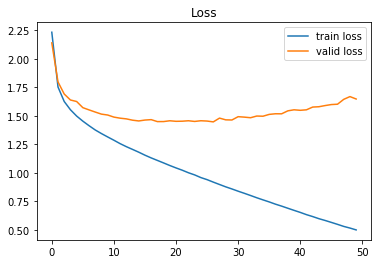

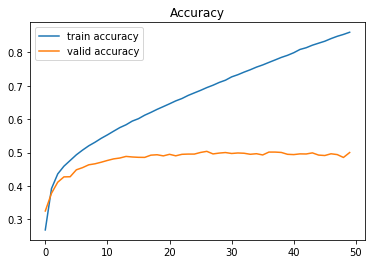

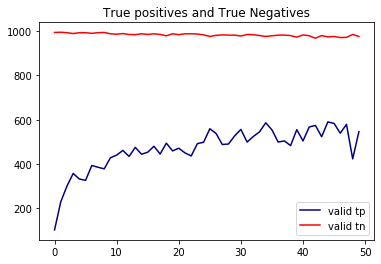

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

plt.plot(range(len(valid_tp)), valid_tp, label="valid tp", color="navy")
plt.plot(range(len(valid_tn)), valid_tn, label="valid tn", color="red")
plt.legend()
plt.title("True positives and True Negatives")
plt.show()
